<a href="https://colab.research.google.com/github/jadechip/on-chain-analytics-lstm/blob/master/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import io
import json
import requests
import functools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

## Bitcoin price

In [0]:
def make_request(url, *args):
  print(url(*args))
  return requests.get(url(*args))

In [0]:
start      = 20100718
end        = 20180429
params     = "PriceUSD"
url        = lambda params: f"https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics={params}&start={start}&end={end}"

In [39]:
response = make_request(url, "PriceUSD")

https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics=PriceUSD&start=20100718&end=20180429


In [0]:
json = response.json()

In [0]:
price_df = pd.DataFrame(json["metricData"]["series"])
price_df["values"] = price_df["values"].apply(lambda x: x[0])
price_df["values"] = price_df["values"].astype(float)

In [0]:
price_df['time'] = pd.to_datetime(price_df['time'])
price_df['time'] = price_df['time'].dt.strftime('%d-%m-%Y')

In [43]:
price_df.head()

,time,values
0,18-07-2010,0.085840
1,19-07-2010,0.080800
2,20-07-2010,0.074736
3,21-07-2010,0.079193
4,22-07-2010,0.058470


## Metrics

In [0]:
start      = 1279324800
end        = 1524960000
metrics_df = pd.DataFrame()
api_key    = "5a0cf8d7-d14a-44f4-b063-a76807cd5340"
base       = "https://api.glassnode.com/v1"
url        = lambda api_key: f"{endpoint}?api_key={api_key}&a=BTC&s={start}&u={end}"
endpoints  = {
  "dormancy" : f"{base}/metrics/indicators/average_dormancy",
  "velocity" : f"{base}/metrics/indicators/velocity",
  "nvts"     : f"{base}/metrics/indicators/nvts",
  "sopr"     : f"{base}/metrics/indicators/sopr",
  "mvrv"     : f"{base}/metrics/market/mvrv" 
}

In [45]:
for name, endpoint in endpoints.items():
  response = make_request(url, api_key)
  tmp = pd.read_json(response.content, convert_dates=["t"], date_unit="s")
  tmp.columns = ["date", name]
  diff = tmp.columns.difference(metrics_df.columns)
  metrics_df = pd.concat([metrics_df, tmp[diff]], axis=1, sort=False)

https://api.glassnode.com/v1/metrics/indicators/average_dormancy?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/velocity?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/nvts?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/sopr?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/market/mvrv?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000


### Join

In [0]:
metrics_df["target_price"] = price_df["values"]

In [0]:
metrics_df = metrics_df.set_index("date", drop=True)

In [48]:
metrics_df.head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2010-07-17,17.557391,0.009522,50.456801,1.000000,1.000000,0.085840
2010-07-18,37.898148,0.012926,65.719591,1.174760,1.299792,0.080800
2010-07-19,8.009980,0.016157,91.505617,1.318536,1.813274,0.074736
2010-07-20,2.325436,0.011241,79.848213,1.090517,1.584801,0.079193
2010-07-21,23.594423,0.010933,70.508828,1.065532,1.398245,0.058470


### Test-Training split

In [79]:
training_data, validation_data = train_test_split(metrics_df, test_size=0.2, shuffle=False)
validation_data, testing_data = train_test_split(validation_data, test_size=0.5, shuffle=False)

print(f"Training data size: {training_data.shape}",
      f"Validation data size: {validation_data.shape}",
      f"Testing data size: {testing_data.shape}")

data = {
  "training" : training_data,
  "validation" : validation_data,
  "testing" : testing_data,
}

Training data size: (2274, 6) Validation data size: (284, 6) Testing data size: (285, 6)


### Normalize

In [0]:
normalize = lambda df: (df - df.mean()) / (df.max() - df.min())

In [0]:
# If normalization is applied on the test data, 
# there is a chance that some information will be leaked from training set into the test set.
data["training"] = normalize(data["training"])

In [82]:
data["training"].head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2010-07-17,0.056365,-0.024932,0.175394,-0.011233,-0.112489,-0.197668
2010-07-18,0.154275,-0.024165,0.264575,0.128719,-0.068433,-0.197673
2010-07-19,0.010409,-0.023438,0.415242,0.243857,0.007027,-0.197678
2010-07-20,-0.016954,-0.024545,0.347128,0.061255,-0.026549,-0.197674
2010-07-21,0.085424,-0.024614,0.292558,0.041247,-0.053964,-0.197692


In [53]:
data["testing"].head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2017-07-18,3.544895,0.116358,9.289307,1.009604,2.440999,2257.065236
2017-07-19,3.830247,0.110743,9.365939,1.007603,2.468360,2823.897926
2017-07-20,4.511744,0.116476,10.010023,1.023805,2.642008,2666.139718
2017-07-21,4.534660,0.098986,10.835737,1.016326,2.859568,2829.754055
2017-07-22,3.952276,0.081912,11.005680,1.018288,2.907173,2753.243865


### Hyperparameters

In [0]:
EPOCHS        = 1000
DROPOUT       = 0.2
DIRECTIONS    = 1
NUM_LAYERS    = 2
BATCH_SIZE    = 5
OUTPUT_SIZE   = 1
SEQ_LENGTH    = 90 # 90 day average
NUM_FEATURES  = 5
HIDDEN_SIZE   = 12
LEARNING_RATE = 0.0001

### Feature Selection

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class MetricsDataset(Dataset):
    """Metrics dataset."""

    def __init__(self, csv_file, seq_length):
        """
        Args:
        """
        self.csv_file = csv_file
        self.target = "target_price"
        self.features = ["dormancy", "velocity", "nvts", "sopr", "mvrv"]
        
        self.seq_length = seq_length
        self.data_length = len(csv_file)

        self.metrics = self.create_xy_pairs()

    def create_xy_pairs(self):
        pairs = []
        for idx in range(self.data_length - self.seq_length):
            x = self.csv_file[idx:idx + self.seq_length][self.features].values
            y = self.csv_file[idx + self.seq_length:idx + self.seq_length + 1][self.target].values
            pairs.append((x, y))
        return pairs

    def __len__(self):
        return len(self.metrics)

    def __getitem__(self, idx):
        return self.metrics[idx]

In [0]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'drop_last': True, # Disregard last incomplete batch
          'num_workers': 4}

training_ds = MetricsDataset(data["training"], SEQ_LENGTH)
training_dl = DataLoader(training_ds, **params)

validation_ds = MetricsDataset(data["validation"], SEQ_LENGTH)
validation_dl = DataLoader(validation_ds, **params)

testing_ds = MetricsDataset(data["testing"], SEQ_LENGTH)
testing_dl = DataLoader(testing_ds, **params)

### Initialize model, criterion and optimizer



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils import data
from torch.nn import functional as F
from torchvision import datasets, models, transforms

In [0]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
    self.dropout = nn.Dropout(dropout_prob)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, states):
    x, (h, c) = self.lstm(x, states)
    out = self.linear(x)
    return out, (h, c)

In [0]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [0]:
model = LSTM(
    NUM_FEATURES,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [0]:
def training(model, epochs, state_dim, validate_every=4):

    training_losses = []
    validation_losses = []

    for epoch in range(epochs):

        # Set to train mode
        model.train()

        # Initialize hidden and cell states with dimension:
        # (num_layers * num_directions, batch, hidden_size)
        states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
        running_training_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(training_dl):
            
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            optimizer.zero_grad()
            
            # Truncated Backpropagation
            states = [state.detach() for state in states]          
            
            # Make prediction
            output, states = model(x_batch, states)

            # Calculate loss
            loss = criterion(output[:, -1, :], y_batch)
            loss.backward()
            running_training_loss += loss.item()

            torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()

            print(f"Epoch {epoch+1}/{epochs}", 
                  f"Index: {idx + 1}",
                  f"Loss: {loss.item()}")
            
        training_losses.append(running_training_loss / len(training_dl))
        
        if epoch % validate_every == 0:

            # Set to eval mode
            model.eval()

            validation_states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
            running_validation_loss = 0.0

            with torch.no_grad():
                for idx, (x_batch, y_batch) in enumerate(validation_dl):

                    # Convert to Tensors
                    x_batch = x_batch.float().to(device)
                    y_batch = y_batch.float().to(device)
                  
                    validation_states = [state.detach() for state in validation_states]
                    
                    output, validation_states = model(x_batch, validation_states)
                    validation_loss = criterion(output[:, -1, :], y_batch)
                    running_validation_loss += validation_loss.item()

                    print(f"Epoch {epoch+1}/{epochs}", 
                          f"Index: {idx + 1}",
                          f"Loss: {loss.item()}")

                validation_losses.append(running_validation_loss / len(validation_dl))

    # Visualize loss
    epoch_count = range(1, len(training_losses) + 1)
    plt.plot(epoch_count, training_losses, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    val_epoch_count = range(1, len(validation_losses) + 1)
    plt.plot(val_epoch_count, validation_losses, 'b-')
    plt.legend(['Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 1/20 Index: 1 Loss: 0.006476858165115118
Epoch 1/20 Index: 2 Loss: 0.006587573792785406
Epoch 1/20 Index: 3 Loss: 0.006885594222694635
Epoch 1/20 Index: 4 Loss: 0.00649667251855135
Epoch 1/20 Index: 5 Loss: 0.006385594606399536
Epoch 1/20 Index: 6 Loss: 0.006516855210065842
Epoch 1/20 Index: 7 Loss: 0.006032859440892935
Epoch 1/20 Index: 8 Loss: 0.006111626513302326
Epoch 1/20 Index: 9 Loss: 0.006445472594350576
Epoch 1/20 Index: 10 Loss: 0.005856852978467941
Epoch 1/20 Index: 11 Loss: 0.0064456709660589695
Epoch 1/20 Index: 12 Loss: 0.0071295783855021
Epoch 1/20 Index: 13 Loss: 0.0060192374512553215
Epoch 1/20 Index: 14 Loss: 0.00674313073977828
Epoch 1/20 Index: 15 Loss: 0.006602063775062561
Epoch 1/20 Index: 16 Loss: 0.005963455885648727
Epoch 1/20 Index: 17 Loss: 0.006725114770233631
Epoch 1/20 Index: 18 Loss: 0.006184264551848173
Epoch 1/20 Index: 19 Loss: 0.00608594436198473
Epoch 1/20 Index: 20 Loss: 0.0067244055680930614
Epoch 1/20 Index: 21 Loss: 0.0063912044279277325
Ep

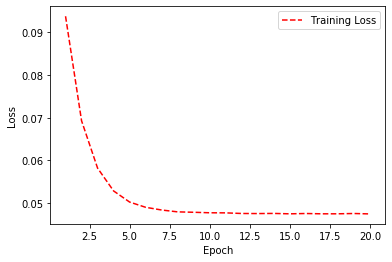

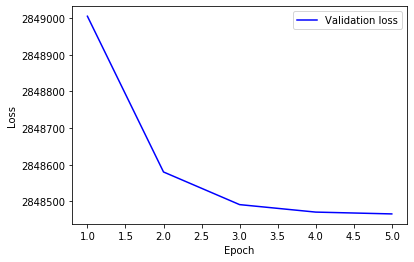

In [85]:
training(model, 20, state_dim=(NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE))

In [0]:
state_dim = (NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE)

def make_predictions(input, num_predictions):
    model.eval()
    predictions = []
    for i in range(num_predictions):
        with torch.no_grad():


        
          states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
          predictions.append(model(input, states).item())
  return predictions

In [0]:
# note: batch normalization instead of general normalization

# Make 1 prediction

test_window = test_data[:SEQ_LENGTH]
test_tensor = torch.tensor(test_window.values).float()
test_batch = test_tensor.view(1, SEQ_LENGTH).to(device)
make_predictions(test_tensor, 1)

In [58]:
torch.from_numpy(testing_data.iloc[50][["dormancy", "velocity", "nvts", "sopr", "mvrv"]].values).float()

tensor([ 6.3115,  0.0595, 10.0556,  1.0050,  1.8457])

In [0]:
# https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

def predict_sequences_multiple(model, data, window_size, prediction_len):
  prediction_seqs = []
  for i in range(int(len(data)/prediction_len)):
    curr_frame = data[i*prediction_len]
    predicted = []
    with torch.no_grad():
      for j in range(prediction_len):
        predicted.append(model(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
      prediction_seqs.append(predicted)
  return prediction_seqs

In [44]:
predict_sequences_multiple(model, testing_data, SEQ_LENGTH, 50)

KeyError: ignored

In [0]:
from tqdm import tqdm

In [34]:
model.eval()

state_dim = (NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE)
validation_states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
running_validation_loss = 0.0

predictions = []
with torch.no_grad():
    for idx, (x_batch, y_batch) in enumerate(tqdm(validation_dl)):

        # Convert to Tensors
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)
      
        validation_states = [state.detach() for state in validation_states]
        
        output, validation_states = model(x_batch, validation_states)
        import pdb; pdb.set_trace()
        predictions.append(output[:, -1, :])

  0%|          | 0/436 [00:00<?, ?it/s]

> <ipython-input-34-d802e7a2c1a9>(19)<module>()
-> predictions.append(output[:, -1, :])
(Pdb) output
tensor([[[0.0241],
         [0.0118],
         [0.0052],
         [0.0018],
         [0.0011],
         [0.0009],
         [0.0014],
         [0.0029],
         [0.0034],
         [0.0047],
         [0.0054],
         [0.0050],
         [0.0044],
         [0.0041],
         [0.0043],
         [0.0040],
         [0.0038],
         [0.0037],
         [0.0040],
         [0.0039],
         [0.0040],
         [0.0046],
         [0.0049],
         [0.0047],
         [0.0045],
         [0.0041],
         [0.0038],
         [0.0038],
         [0.0036],
         [0.0036],
         [0.0036],
         [0.0035],
         [0.0037],
         [0.0036],
         [0.0035],
         [0.0036],
         [0.0039],
         [0.0038],
         [0.0037],
         [0.0036],
         [0.0035],
         [0.0037],
         [0.0036],
         [0.0036],
         [0.0035],
         [0.0039],
         [0.0040],
      

BdbQuit: ignored

ValueError: ignored

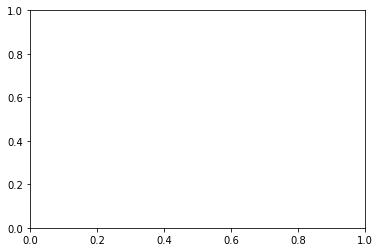

In [33]:
preds_epoch_count = range(1, len(predictions) + 1)
plt.plot(preds_epoch_count, predictions, 'b-')
plt.legend(['Predictions'])
plt.xlabel('Epoch')
plt.ylabel('Predictions')
plt.show()